In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import glob
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Flatten, Reshape, Convolution1D, Conv1D, \
    MaxPooling1D, UpSampling1D,Cropping1D, LSTM, RepeatVector,Activation, TimeDistributed
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Process description
Below is the scheme of the pilot plant (adapted from Process summary, the ChemEng Discovery space, Imperial College London). There are six sampling points between stages, and all the sampling points are fed to the same gas analyzer. However, the gas analyzer can only process the sampling stream one at a time, i.e., at any given time, there is only one position that the gaseous $CO_2$ concentration is known.
<img src="images/pilot_plant.jpg" width="500">

In [2]:
# Records in the spreadsheet are are already labelled
data_path_list = glob.glob('./data/withLabel/1*.xlsx')
list_of_origin_df=[]
for i in range(len(data_path_list)):
    xls = pd.ExcelFile(data_path_list[i])
    data_df = pd.read_excel(xls, sheet_name=0, index_col=0, header = [0,1])
    data_df.columns = data_df.columns.map(''.join)
    data_df=data_df.rename_axis('time').reset_index()
    tmp_name=list(data_df.columns)
    tmp_name[-1]='label'
    data_df.columns=tmp_name
    list_of_origin_df.append(data_df)

Labelled process record:

In [3]:
list_of_origin_df[0].head()

,time,AT100(pH),AT300(pH),AT400(CO2 %),FT100(kg/hr),FT101(kg/hr),FT102(kg/hr),FT103(kg/hr),FT104(kg/hr),FT105(L/min),...,TT400(0C),TT401(0C),TT402(0C),TT403(0C),TT404(0C),TT410(0C),TT411(0C),TT412(0C),TT413(0C),label
0,2014-01-20 17:23:02,10.468116,10.856668,0.109407,49.641636,0,114.306496,253.188339,244.473846,0.076785,...,117.106621,116.955292,116.753510,22.537117,104.836342,22.658978,34.482868,36.524200,33.270100,1
1,2014-01-20 17:23:46,10.429050,10.856927,0.098878,49.669559,0,73.167267,253.357178,244.543427,0.076773,...,116.413254,116.233284,116.142960,22.537117,105.931946,22.678768,33.612118,35.468010,32.640736,1
2,2014-01-20 17:24:29,10.380840,10.868021,0.001587,49.750290,0,30.941877,254.384949,244.684982,0.076896,...,115.733566,115.700668,115.546623,22.537117,106.712189,22.689386,32.948505,34.523560,32.053650,1
3,2014-01-20 17:25:12,10.319781,10.888022,0.000000,49.734818,0,65.672806,254.687668,244.545029,0.076057,...,115.841347,115.708611,115.522621,22.537117,107.563896,22.699842,32.655727,33.851078,31.548174,2
4,2014-01-20 17:25:55,10.248368,10.903030,0.000364,49.566025,0,15.200113,254.401810,244.331406,0.076959,...,114.879135,114.479225,114.496765,22.537117,107.848602,22.714924,32.635029,33.495365,31.267054,2


The measurements consist of 53 temperature transmitters, 11 pressure transmitters, 19 flow transmitters, 4 level transmitters, 2 pH analyzers and the previously discussed gas concentration analyzer. The measurements cover the pilot plant process including the elements shown in previous figure as well as the various gas handling and storage systems and the auxiliary processes. Key measurements of the absorber column include (with descriptions on the P&ID):

* FT103: Flow transmitter, $CO_2$ lean amine solution, valid range 120-12000 kg/hr.
* FT104: Flow transmitter, $CO_2$ lean amine solution, valid range 100-1600 kg/hr, connects in serial with FT103.
* TT210: Temperature transmitter, temperature of $CO_2$ lean amine solution, K.
* TT211: Temperature transmitter, temperature of $CO_2$ lean amine solution, K, connects in serial with TT210.
* FT303: Flow transmitter, $N_2$ absorber inlet (volumetric) flowrate, valid range 38.7-575 kg/hr.
* FT304: Flow transmitter, $N_2$ absorber inlet flowrate, valid range 4.4-438 kg/hr, connects in serial with FT303.
* PT403: Pressure transmitter, $N_2$ absorber inlet pressure, valid range -1-4 barG.
* TT304: Temperature transmitter, $N_2$ absorber inlet temperature, K.
* FT301: Flow transmitter, $CO_2$ absorber inlet (volumetric) flowrate, valid range 7.14-71.4 kg/hr.
* FT302: Flow transmitter, $CO_2$ absorber inlet flowrate, valid range 1.56-156 kg/hr, connects in serial with FT301.
* PT402: Pressure transmitter, $CO_2$ absorber inlet pressure, valid range -1-4 barG.
* TT104: Temperature transmitter, temperature of $N_2, CO_2$ mixture at absorber inlet, K.
* PT111: Pressure transmitter, bottom of the absorber, valid range -1-4 barG.
* PT403: Pressure transmitter, top of the absorber, valid range -1-4 barG.

Note the pressure transmitter of $N_2$ and of the top of the absorber is the same. The lean gas ($N_2$) is recycled from top of the absorber and mix with the $CO_2$, and forms the $CO_2$-rich feed gas.

# Kinetic (dynamic) modeling
Instead of implementing complicated kinetic correlations, we fit a pseudo reaction to approximate the absorption process
$CO_{2,(g)} + MEA_{(l)} \underset{reaction_2}{\stackrel{reaction_1}{\rightleftharpoons}} \left[ CO_2-MEA\right]_{binded_{(l)}}$

$R_1 = k_1 \cdot \exp^{\frac{-E_{A1}}{8.314\left(\alpha_1\cdot T +\beta_1\right)}}$,
$R_2 = k_2 \cdot \exp^{\frac{-E_{A2}}{8.314\left(\alpha_2\cdot T+\beta_2\right)}}$,

The vector of parameters are combined as x0 = [$k_1, \alpha_1, \beta_1, k_2, \alpha_2, \beta_2$]

kinetic_model contains the Simulink model of the absorber. Please note that the parameters in the Simulink model are outdated and need to be run by Matlab script to update these parameters.
The result_generation ran the kinetic_model with the fitted parameter: x0=[500.6,1,1005.5,4380,1,1263]. The results are tagged as "time stamp.csv". A schematic of the Simulink model is shown below:

<img src="images/kinetic_scheme.png" width="1000">

# data-driven modeling

In [4]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(0)
    tf.random.set_seed(0)
    np.random.seed(0)
    random.seed(0)
    
def rmse(pred, label):
    return np.sqrt(((pred - label) ** 2).mean())

def avgOutPoint1(df):
    #Change point 1 readings to Avg. of Point 2.
    label_list=list(df['label'])
    conc_list = list(df['AT400(CO2 %)'])
    p=0
    num=0
    i=0
    sampling2_avgcon = list()
    while i<len(label_list):
        if label_list[i]==2:
            p=p+conc_list[i]
            num=num+1
            i=i+1
        else:
            if p ==0 and num==0:
                i=i+1
                pass
            else:
                sampling2_avgcon.append(p/num)
                i =i+1
                num=0
                p=0

    i=0
    k=-1
    while i<(len(label_list)-1):
        if label_list[i]==1:
            conc_list[i]=sampling2_avgcon[k]
            i=i+1
        else:
            if label_list[i+1]==1 :
                k=k+1
                i=i+1
            else:
                i=i+1
    #set new AT400
    df['AT400(CO2 %)']=pd.Series(data=conc_list,index=df.index)
    return df

def columnSeparator(df):
    # linear interpolation to fill missing values
    for i in range(1,7): # 6 sampling points
        new_con =list()
        j = 0
        while j<df.shape[0]:
            if df.iloc[j]['label']==i:
                new_con.append( df.iloc[j]['AT400(CO2 %)'])
                j = j+1
            else:
                new_con.append(np.nan)
                j = j+1
        df[str(i)+"_sampling"]=pd.Series(data=new_con,index=df.index)
        df[str(i)+"_sampling"]=df[str(i)+"_sampling"].interpolate(method="linear")
    # Notice the df will contain NaN for the first few rows for each sampling point column
    return df

def getU(ens,reduced_dimension):
    # assuming ens has shape of [sampe_size, sample_ravel()]
    u, s, vh = np.linalg.svd(ens.T, full_matrices=False)
    truncation_parameter = reduced_dimension
    print('Truncation parameter: ',truncation_parameter)
    u1=u[:,:truncation_parameter]
    s1=s[:truncation_parameter]
    vh1=vh[:truncation_parameter,:]
    return u1

def dfPOD(train_df_list, test_df_list, _train_feature_list, _label_list, reduced_dimension):
    print('Train df(1st one) shape before POD: ', train_df_list[0].shape)
    print('Test df(1st one) shape before POD: ', test_df_list[0].shape)
    
    label_list=_label_list.copy()
    train_feature_list=_train_feature_list.copy()
    #train_feature_list.remove('AT400(CO2 %)')
    #label_list.append('AT400(CO2 %)')
    
    for i in range(len(train_df_list)):
        if (i==0):
            train_full_values=train_df_list[i][train_feature_list].values
            train_label_values=train_df_list[i][label_list].values
        else:
            train_full_values=np.concatenate((train_full_values, train_df_list[i][train_feature_list].values), axis=0)
            train_label_values=np.concatenate((train_label_values, train_df_list[i][label_list].values), axis=0)
    for i in range(len(test_df_list)):
        if (i==0):
            test_full_values=test_df_list[i][train_feature_list].values
            test_label_values=test_df_list[i][label_list].values
        else:
            test_full_values=np.concatenate((test_full_values, test_df_list[i][train_feature_list].values), axis=0)
            test_label_values=np.concatenate((test_label_values, test_df_list[i][label_list].values), axis=0)
    
    n_set = train_full_values.shape[0]
    train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
    test_index = list(set(range(0,n_set,5)))
    
    x_train = train_full_values[train_index]; x_val = train_full_values[test_index]
    x_test = test_full_values; 

    u1 = getU(x_train, reduced_dimension)

    x_train_encoded = u1.T @ x_train.T # shape [truncation_parameter, sample size]
    x_val_encoded = u1.T @ x_val.T
    x_test_encoded = u1.T @ x_test.T

    x_train_decoded = (u1 @ x_train_encoded).T # shape [sampe_size, sample_ravel()]
    x_val_decoded = (u1 @ x_val_encoded).T
    x_test_decoded = (u1 @ x_test_encoded).T
    
    print("Train: ", mean_squared_error(x_train,x_train_decoded));
    print("Val: ", mean_squared_error(x_val,x_val_decoded));
    print("Test: ", mean_squared_error(x_test,x_test_decoded));
    
    encoded_train= (u1.T @ train_full_values.T).T#.reshape(train_full_values.shape[0],train_full_values.shape[2])
    encoded_test= (u1.T @ test_full_values.T).T#.reshape(test_full_values.shape[0],test_full_values.shape[2])
    encoded_name_list=['encoded_{}'.format(i) for i in range(1,encoded_train.shape[1]+1)]
    upper_index=0
    bottom_index=0
    for i in range(len(train_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+train_df_list[i].shape[0]
        train_df_list[i]=pd.DataFrame(np.concatenate((encoded_train[upper_index:bottom_index,:],train_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    upper_index=0
    bottom_index=0
    for i in range(len(test_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+test_df_list[i].shape[0]
        test_df_list[i]=pd.DataFrame(np.concatenate((encoded_test[upper_index:bottom_index,:],test_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    print('Train df(1st one) shape after AE: ', train_df_list[0].shape)
    print('Test df(1st one) shape after AE: ', test_df_list[0].shape)
    return train_df_list,test_df_list

def dfAE(train_df_list, test_df_list, _train_feature_list, _label_list, reduced_dimension):
    print('Train df(1st one) shape before AE: ', train_df_list[0].shape)
    print('Test df(1st one) shape before AE: ', test_df_list[0].shape)
    
    label_list=_label_list.copy()
    train_feature_list=_train_feature_list.copy()
    #train_feature_list.remove('AT400(CO2 %)')
    #label_list.append('AT400(CO2 %)')
    
    for i in range(len(train_df_list)):
        if (i==0):
            train_full_values=train_df_list[i][train_feature_list].values
            train_label_values=train_df_list[i][label_list].values
        else:
            train_full_values=np.concatenate((train_full_values, train_df_list[i][train_feature_list].values), axis=0)
            train_label_values=np.concatenate((train_label_values, train_df_list[i][label_list].values), axis=0)
    for i in range(len(test_df_list)):
        if (i==0):
            test_full_values=test_df_list[i][train_feature_list].values
            test_label_values=test_df_list[i][label_list].values
        else:
            test_full_values=np.concatenate((test_full_values, test_df_list[i][train_feature_list].values), axis=0)
            test_label_values=np.concatenate((test_label_values, test_df_list[i][label_list].values), axis=0)
    
    n_set = train_full_values.shape[0]
    train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
    test_index = list(set(range(0,n_set,5)))
    
    x_train = train_full_values[train_index]; x_val = train_full_values[test_index]
    x_test = test_full_values; 
    print('LSTM x_train shape: ', x_train.shape[0])

    noise_factor = 0.1
    scale_arr = np.var(x_train,axis=0)
    x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=scale_arr, size=x_train.shape) 
    x_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=scale_arr, size=x_test.shape) 
    x_train = np.clip(x_train, 0., 1.)
    x_test = np.clip(x_test, 0., 1.)
    # AE shape default design
    input_img = Input(shape=(x_train.shape[1]))
    x = Dense(64,activation='relu',kernel_initializer=ReLu)(input_img)
    encoded = Dense(reduced_dimension,activation='relu',kernel_initializer=ReLu)(x)


    encoder = Model(input_img, encoded)
    encoder.summary()

    decoder_input = Input(shape=(reduced_dimension))

    x = Dense(64)(decoder_input)
    decoded = Dense(x_train.shape[1], activation='sigmoid')(x)

    decoder = Model(decoder_input, decoded)
    decoder.summary()

    encoder=Model(inputs=input_img, outputs=encoded, name = 'encoder')
    decoder=Model(inputs=decoder_input, outputs=decoded, name = 'decoder')
    autoencoder_outputs = decoder(encoder(input_img))
    autoencoder= Model(input_img, autoencoder_outputs, name='autoencoder')
    autoencoder.summary()
    #Optimizers 
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt, loss="mse")

    # Set callback functions to early stop training and save the best model so far
    early_stopping_monitor = [EarlyStopping(monitor='val_loss', patience=30, verbose=0,restore_best_weights=True)]

    history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=40,shuffle=True, 
                              validation_data=(x_val, x_val), callbacks=early_stopping_monitor)
    autoencoder.save(os.path.join('DAE'))
    autoencoder=keras.models.load_model(os.path.join('DAE'))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    print('Train RMSE: ',rmse(x_train,autoencoder.predict(x_train)))
    print('Val RMSE: ',rmse(x_val,autoencoder.predict(x_val)))
    print('Test RMSE: ',rmse(x_test,autoencoder.predict(x_test)))
    
    encoder = autoencoder.get_layer("encoder")
    encoded_train=encoder.predict(train_full_values)#.reshape(train_full_values.shape[0],train_full_values.shape[2])
    encoded_test=encoder.predict(test_full_values)#.reshape(test_full_values.shape[0],test_full_values.shape[2])
    encoded_name_list=['encoded_{}'.format(i) for i in range(1,encoded_train.shape[1]+1)]
    upper_index=0
    bottom_index=0
    for i in range(len(train_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+train_df_list[i].shape[0]
        train_df_list[i]=pd.DataFrame(np.concatenate((encoded_train[upper_index:bottom_index,:],train_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    upper_index=0
    bottom_index=0
    for i in range(len(test_df_list)):
        upper_index=bottom_index
        bottom_index=upper_index+test_df_list[i].shape[0]
        test_df_list[i]=pd.DataFrame(np.concatenate((encoded_test[upper_index:bottom_index,:],test_df_list[i][label_list].values),axis=1),
                                     columns=encoded_name_list+label_list)
    print('Train df(1st one) shape after AE: ', train_df_list[0].shape)
    print('Test df(1st one) shape after AE: ', test_df_list[0].shape)
    return train_df_list,test_df_list

def getSampleSet(df_list, callback, train_feature_list, label_list):
    conc_label_list=[]
    for i in range(len(df_list)):
        # The 1st element in label list is label
        nset = df_list[i].shape[0]-callback
        print("Number of set: ", nset)
        conc_input=np.zeros((df_list[i].shape[0],6)) # Only the true reading is non-zero
        conc_set = df_list[i][label_list[1:]].values # Excl. 1st column, label column
        conc_set[np.isnan(conc_set)]=0
        parameter_set = df_list[i][train_feature_list].values
        for k in range(conc_input.shape[0]): # Only the true reading is non-zero, default for onehot
            conc_input[k][int(df_list[i]['label'][k])-1]=1        
        conc_input[np.isnan(conc_input)]=0
        parameter_set=np.hstack((parameter_set,conc_input))
        sample_set=np.zeros((nset,callback+1,parameter_set.shape[1]))
        label_set=np.zeros((nset,1,conc_set.shape[1]))
        for j in range(nset):
            sample_set[j]=parameter_set[0+j:callback+j+1]
            label_set[j]=conc_set[callback+j]
        
        if (i==0):
            total_sample_set=np.zeros((0,callback+1,parameter_set.shape[1]))
            total_label_set=np.zeros((0,1,conc_set.shape[1]))
        conc_label_list.append(label_set)
        total_sample_set = np.vstack([total_sample_set,sample_set])
        total_label_set = np.vstack([total_label_set,label_set])
        
    return total_sample_set, total_label_set, conc_label_list
        

def getDataSet(path_list,df_list, callback, test_df_index_list, mode, reduced_dimension):
    # Pre-processing: avg. out Conc @ sampling point 1
    print('Timestamp in selected Test df list: ')
    for i in range(len(test_df_index_list)):
        print(os.path.basename(path_list[test_df_index_list[i]]))
    for i in range(len(df_list)):
        df_list[i]=df_list[i].set_index('time')
        #df_list[i]=df_list[i].drop(columns=["time"])
        df_list[i] = avgOutPoint1(df_list[i])
        if (i==0):
            origin_feature_num = df_list[i].shape[1]
            print("Origin input DF feature num(excl time, incl. label): ", origin_feature_num)

    # Separate df_list into Train & Test df lists
    test_df_list = list(pd.Series(df_list)[test_df_index_list]) # The 140207_1 is selected as the testset
    train_df_list = list(pd.Series(df_list)[list(set(range(0,len(df_list),1))-set(test_df_index_list))])

    #Min-max scaler, calculated from train_df_list
    for i in range(len(train_df_list)):
        if (i==0):
            tmp_full_values=train_df_list[i].values
            tmp_conc_values=train_df_list[i]['AT400(CO2 %)'].values
        else:
            tmp_full_values=np.concatenate((tmp_full_values, train_df_list[i].values), axis=0)
            tmp_conc_values=np.concatenate((tmp_conc_values, train_df_list[i]['AT400(CO2 %)'].values), axis=0)
    tmp_full_values = tmp_full_values[:,:-1] # excl. label column as well
    general_scaler = MinMaxScaler()
    conc_scaler = MinMaxScaler()
    general_scaler.fit(tmp_full_values)
    conc_scaler.fit(tmp_conc_values.reshape(-1,1))

    print('Conc scaler max: ',conc_scaler.data_max_)

    # Process into + ['label', '1_sampling', '2_sampling', '3_sampling', '4_sampling', '5_sampling', '6_sampling']
    for i in range(len(df_list)):
        df_list[i].iloc[:,:-1] = general_scaler.transform(df_list[i].iloc[:,:-1].values)
        df_list[i] = columnSeparator(df_list[i])
        df_list[i]=df_list[i].fillna(0)

    nan_num = 0
    for df in df_list:
        avail_index = (df['6_sampling']>=0).argmax()
        if (nan_num < avail_index):
            nan_num = avail_index
    print("Minimum call back is: ", nan_num+1)
    if (nan_num+1<callback):
        print('The smallest feasible callback is: ', nan_num+1)

    # Separate df_list into Train & Test df lists
    test_df_list = list(pd.Series(df_list)[test_df_index_list]) # The 140207_1 is selected as the testset
    train_df_list = list(pd.Series(df_list)[list(set(range(0,len(df_list),1))-set(test_df_index_list))])

    print("train list: ", len(train_df_list))
    label_list=['label', '1_sampling', '2_sampling', '3_sampling', '4_sampling', '5_sampling', '6_sampling']
    train_feature_list = list(np.sort(list(set(df_list[0].columns)-set(label_list))))
    if (mode == 'PCA'):
        if (reduced_dimension == 16):
            train_feature_list = ['TT113(0C)','TT300(0C)','TT302(0C)','TT202(0C)','TT304(0C)',"TT400(0C)",
                                  "TT410(0C)",'PT103(barg)','PT402(barg)','PT403(barg)','PT102(barg)' ,'AT300(pH)',
                                  'FT302(kg/hr)', 'FT303m3/hr','FT304(kg/hr)','FT103(kg/hr)']
        else:
            train_feature_list = ['TT302(0C)','TT300(0C)','TT401(0C)','TT303(0C)','TT400(0C)','TT113(0C)',
                                  'TT301(0C)','TT202(0C)','TT412(0C)','TT309(0C)','TT110a(0C)','TT410(0C)',
                                  'TT112(0C)','PT103(barg)','PT402(barg)','PT401(barg)','TT404(0C)', 'TT214(0C)',
                                  'FT304(kg/hr)','AT100(pH)','FT303m3/hr','AT300(pH)','FT105(L/min)','FT103(kg/hr)',
                                  'PT403(barg)','TT304(0C)','FT301m3/hr','TT107(0C)', 'PT110(barg)','PT111(barg)',
                                  'TT210(0C)','TT211(0C)']
    if (mode == 'DAE'):
        train_df_list, test_df_list=dfAE(train_df_list, test_df_list, train_feature_list, label_list, reduced_dimension)
        train_feature_list = np.sort(list(set(train_df_list[0].columns)-set(label_list)))
    if (mode == 'POD'):
        train_df_list, test_df_list=dfPOD(train_df_list, test_df_list, train_feature_list, label_list, reduced_dimension)
        train_feature_list = np.sort(list(set(train_df_list[0].columns)-set(label_list)))
    train_sample_set, train_label_set,_ = getSampleSet(train_df_list, callback, train_feature_list, label_list)
    test_sample_set, test_label_set,test_conc_list = getSampleSet(test_df_list, callback, train_feature_list, label_list)

    
    return train_sample_set, train_label_set, test_sample_set, test_label_set, conc_scaler, train_df_list, test_df_list, test_conc_list

def GCfunc(i, j, corr_length):
    r = abs(i-j)/corr_length
    if (r>=0 and r<1):
        return (1-pow(r,2)*5/3+pow(r,3)*5/8+pow(r,4)*0.5-pow(r,5)*0.25)
    if (r>=1 and r<2):
        return (4-5*r+pow(r,2)*5/3+pow(r,3)*5/8-pow(r,4)*0.5+pow(r,5)/12-2/3/r)
    else:
        return 0

def covLoc(B, corr_length):
    ls_size=B.shape[0]
    for i in range(ls_size):
        for j in range(ls_size):
            B[i][j] = B[i][j]*GCfunc(i,j,corr_length)
    return B

def trainSequenceLSTM(state, train_sample_set, train_label_set, test_sample_set, test_label_set):
    n_sequence = train_sample_set.shape[1]
    n_feature = train_sample_set.shape[2]
    n_set = train_sample_set.shape[0]
    print('train_sample_set shape: ', train_sample_set.shape)
    
    train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
    test_index = list(set(range(0,n_set,5)))
    x_train = train_sample_set[train_index]; x_val = train_sample_set[test_index]
    y_train = train_label_set[train_index]; y_val = train_label_set[test_index]
    x_test = test_sample_set; y_test = test_label_set
    print('Train len: %d, Val len: %d' %(x_train.shape[0], x_val.shape[0]))
    print('x_train shape: '+str(x_train.shape)+ ', y_train shape:' + str(y_train.shape))

    
    if (state == 'train'):
        model = Sequential()
        model.add(LSTM(100,input_shape=(n_sequence,n_feature), return_sequences=True))
        model.add(keras.layers.Dropout(0.1))
        model.add(Dense(100))
        model.add(keras.layers.Dropout(0.1))
        model.add(Dense(100))
        model.add(keras.layers.Dropout(0.1))
        model.add(Dense(6, activation='sigmoid'))
        
        #Optimizers 
        #opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
        opt = tf.keras.optimizers.Adam(learning_rate=0.00001)

        #model.compile(optimizer=opt, loss=my_loss_fn)
        model.compile(optimizer=opt, loss='mse')
        model.summary()
        # Set callback functions to early stop training and save the best model so far
        early_stopping_monitor = [EarlyStopping(monitor='val_loss', patience=70, verbose=0,restore_best_weights=True)]
        
        # fit model
        train_log = model.fit(x_train, y_train, batch_size=40, epochs=500, shuffle=True, 
                               validation_data=(x_val, y_val), callbacks=early_stopping_monitor)
        LSTM_model = model
        #Note the label
        model.save('LSTM_MSE.h5')

        plt.plot(train_log.history['loss'])
        plt.plot(train_log.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    else:
        model = keras.models.load_model('LSTM_MSE.h5')
    
    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    #results = model.evaluate(x_test, y_test, batch_size=36)
    predict_set=model.predict(x_test)
    results = mean_squared_error(conc_scaler.inverse_transform(np.mean(predict_set,axis=1)),conc_scaler.inverse_transform(y_test.reshape(y_test.shape[0],6)))
    print("MSE:", results)
    print('RMSE: ', rmse(conc_scaler.inverse_transform(np.mean(predict_set,axis=1)),conc_scaler.inverse_transform(y_test.reshape(y_test.shape[0],6))))
    
    val_output_set = model.predict(x_val)
    
    print("Evaluate on validation")
    results = mean_squared_error(conc_scaler.inverse_transform(np.mean(val_output_set,axis=1)),conc_scaler.inverse_transform(y_val.reshape(y_val.shape[0],6)))
    print("MSE:", results)
    print('RMSE: ', rmse(conc_scaler.inverse_transform(np.mean(val_output_set,axis=1)),conc_scaler.inverse_transform(y_val.reshape(y_val.shape[0],6))))
    
    R=np.cov((conc_scaler.inverse_transform(np.mean(val_output_set,axis=1))- \
              conc_scaler.inverse_transform(y_val.reshape(y_val.shape[0],6))).T)
    R=covLoc(R,2)
    np.save('R.npy',R)

In [5]:
reset_random_seeds()
ReLu = tf.keras.initializers.HeUniform()
data_path_list = glob.glob('data/WithLabel/1*.xlsx')

list_of_origin_df=[]
for i in range(len(data_path_list)):
    xls = pd.ExcelFile(data_path_list[i])
    data_df = pd.read_excel(xls, sheet_name=0, index_col=0, header = [0,1])
    data_df.columns = data_df.columns.map(''.join)
    data_df=data_df.rename_axis('time').reset_index()
    tmp_name=list(data_df.columns)
    tmp_name[-1]='label'
    data_df.columns=tmp_name
    list_of_origin_df.append(data_df)

for string in data_path_list:
    print(string)
list_of_processed_df=list_of_origin_df.copy()
test_df_index_list=[2] # Select the index of test dataset
callback=17 # length of past records excl. current time step
# getDataSet(path_list,df_list, callback, test_df_index_list, mode, reduced_dimension)
# mode ={'PCA', 'DAE', 'POD'}, reduced_dimension = {'32', '16'}
train_sample_set, train_label_set, test_sample_set, test_label_set, conc_scaler,train_df_list,test_df_list,test_conc_list \
=getDataSet(data_path_list,list_of_processed_df, callback,test_df_index_list, 'POD', 32)

data/WithLabel\140120_1.xlsx
data/WithLabel\140206_1.xlsx
data/WithLabel\140207_1.xlsx
data/WithLabel\140207_2.xlsx
data/WithLabel\140214_1.xlsx
data/WithLabel\140214_2.xlsx
data/WithLabel\140227_1.xlsx
data/WithLabel\140313_1.xlsx
Timestamp in selected Test df list: 
140207_1.xlsx
Origin input DF feature num(excl time, incl. label):  91
Conc scaler max:  [12.03671837]
Minimum call back is:  1
The smallest feasible callback is:  1
train list:  7
Train df(1st one) shape before POD:  (117, 97)
Test df(1st one) shape before POD:  (118, 97)
Truncation parameter:  32
Train:  0.00023401074560962606
Val:  0.00022780908376132073
Test:  0.005939000544029034
Train df(1st one) shape after AE:  (117, 39)
Test df(1st one) shape after AE:  (118, 39)
Number of set:  100
Number of set:  33
Number of set:  33
Number of set:  50
Number of set:  33
Number of set:  201
Number of set:  211
Number of set:  101


train_sample_set shape:  (661, 18, 38)
Train len: 528, Val len: 133
x_train shape: (528, 18, 38), y_train shape:(528, 1, 6)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 18, 100)           55600     
_________________________________________________________________
dropout (Dropout)            (None, 18, 100)           0         
_________________________________________________________________
dense (Dense)                (None, 18, 100)           10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 18, 100)           10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 100)           0        

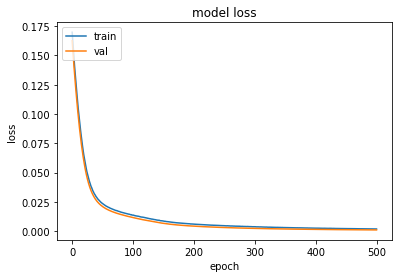

Evaluate on test data
MSE: 0.04703987324763109
RMSE:  0.21688677517919597
Evaluate on validation
MSE: 0.06301061585842911
RMSE:  0.2510191543656163


In [6]:
#LSTM training
trainSequenceLSTM('train', train_sample_set, train_label_set, test_sample_set, test_label_set)
model = keras.models.load_model('LSTM_MSE.h5')
#np.save('results/set2_DAE_16.npy',conc_scaler.inverse_transform(np.mean(predict_set,axis=1)))

Text(0, 0.5, 'CO$_2$ composition(%)')

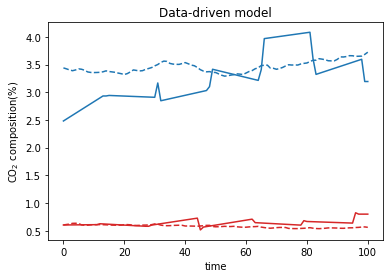

In [7]:
predict_set=np.load('results/set1_DAE_16.npy')
plt.plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6))[:,5], color='tab:blue')
plt.plot(predict_set[:,5],linestyle='dashed',color='tab:blue')
plt.plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6))[:,4], color='tab:red')
plt.plot(predict_set[:,4],linestyle='dashed',color='tab:red')
plt.title('Data-driven model')
plt.xlabel('time')
plt.ylabel('CO$_2$ composition(%)')

Comparison between different dimensionality reduction methods

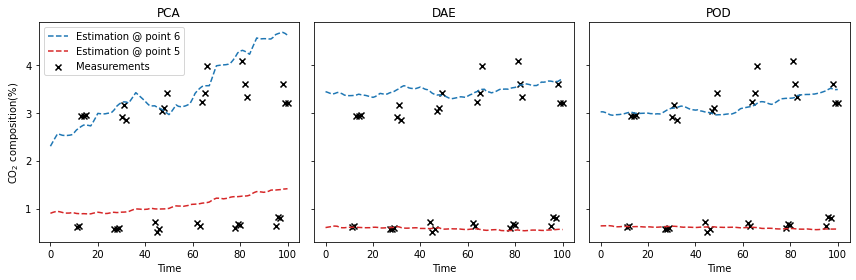

In [8]:
DAE_result = np.load('results/set1_DAE_16.npy')
PCA_result = np.load('results/set1_PCA_16.npy')
POD_result = np.load('results/set1_POD_16.npy')
discrete_record = list_of_origin_df[2]['AT400(CO2 %)'][17:]
sample45 = np.where(discrete_record >0.5,discrete_record,None)
fig, axs = plt.subplots(1,3, sharey=True, figsize=(12,4))
plt.subplots_adjust(wspace = 0.05, bottom=0.15)
fig.set_tight_layout(True)
axs[0].scatter(range(PCA_result.shape[0]), sample45, marker='x', color='black', label='Measurements')
axs[0].plot(PCA_result[:,5],linestyle='dashed',color='tab:blue',label='Estimation @ point 6')
axs[0].plot(PCA_result[:,4],linestyle='dashed',color='tab:red',label='Estimation @ point 5')
axs[0].set_title('PCA')
axs[0].set_ylabel('CO$_2$ composition(%)')
axs[0].set_xlabel('Time')
axs[0].legend()
axs[1].scatter(range(DAE_result.shape[0]), sample45, marker='x', color='black')
axs[1].plot(DAE_result[:,5],linestyle='dashed',color='tab:blue')
axs[1].plot(DAE_result[:,4],linestyle='dashed',color='tab:red')
axs[1].set_title('DAE')
axs[1].set_xlabel('Time')
axs[2].scatter(range(POD_result.shape[0]), sample45, marker='x', color='black')
axs[2].plot(POD_result[:,5],linestyle='dashed',color='tab:blue',label='Fused @ 6')
axs[2].plot(POD_result[:,4],linestyle='dashed',color='tab:red',label='Fused @ 5')
axs[2].set_title('POD')
axs[2].set_xlabel('Time')
#plt.tight_layout()
plt.savefig('reduction_compare.png',dpi=1000)

# Model fusion

kinetic_model\140207_1.csv  in test


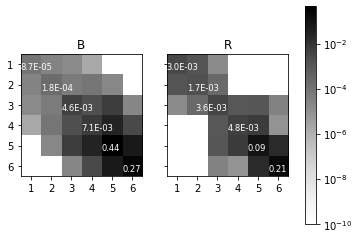

Fused RMSE:  0.10850019921956107


In [9]:
dynamic_path_list = glob.glob('kinetic_model/1*.csv')
def VAR_3D(xb,Y,H,B,R): #booleen=0 garde la trace
    # xb: priori, Y: observation, H: obs. matrix, B: priori estimate uncertainty
    # R: Measurement uncertainty
    dim_x = xb.size
    #dim_y = Y.size
    Y.shape = (Y.size,1)
    xb1=np.copy(xb)
    xb1.shape=(xb1.size,1)
    K=np.dot(B,np.dot(np.transpose(H),np.linalg.pinv(np.dot(H,np.dot(B,np.transpose(H)))+R))) #matrice de gain
    
    A=np.dot(np.dot((np.eye(dim_x)-np.dot(K,H)),B),np.transpose((np.eye(dim_x)-np.dot(K,H))))+np.dot(np.dot(K,R),np.transpose(K))
    vect=np.dot(H,xb1)
    xa=np.copy(xb1+np.dot(K,(Y-vect)))
    return xa.ravel(),A

test_name_list=[]
for i in range(len(test_df_index_list)):
    test_name_list.append(os.path.splitext(os.path.basename(data_path_list[test_df_index_list[i]]))[0])
    
dynamic_df_list=[]
dynamic_train_list=[]
dynamic_test_list=[]
for path in dynamic_path_list:
    dynamic_df_list.append(pd.read_csv(path, header=None))
    if os.path.splitext(os.path.basename(path))[0] not in test_name_list:
        dynamic_train_list.append(pd.read_csv(path, header=None))
    else:
        print(path, ' in test')
        dynamic_test_list.append(pd.read_csv(path, header=None))

for i in range(len(dynamic_train_list)):
    if (i==0):
        train_full_values=dynamic_train_list[i].values[callback:,:]
    else:
        train_full_values=np.concatenate((train_full_values, dynamic_train_list[i].values[callback:,:]), axis=0)
B=np.cov((train_full_values*100-conc_scaler.inverse_transform(train_label_set.reshape(train_label_set.shape[0],6))).T)
B=covLoc(B,2)
np.save('B.npy',B)

for i in range(len(dynamic_test_list)):
    if (i==0):
        test_full_values=dynamic_test_list[i].values[callback:,:]
    else:
        test_full_values=np.concatenate((test_full_values, dynamic_test_list[i].values[callback:,:]), axis=0)

R=np.load('R.npy')
B=np.load('B.npy')
R+=1E-10
B+=1E-10
max_val = np.max([np.max(B),np.max(R)])
fig,axs=plt.subplots(nrows=1, ncols=2,sharey=True)
#im1=axs[0].imshow(B,norm=LogNorm())
#im2=axs[1].imshow(R,norm=LogNorm())
color='Greys'
im1=axs[0].imshow(B,extent=[0,6,0,6], cmap=color,norm=LogNorm(vmin=1E-10, vmax=max_val))
axs[0].set_title('B')
#axs[0].text(5,0.25,str(B[-1,-1])[:4],color='white',size='small')
#axs[0].text(4,1.25,str(B[-2,-2])[:4],color='white',size='small')
for i in range(6):
    if (B[i,i]<0.01):
        axs[0].text(i,5.25-i,'{:.1E}'.format(B[i,i]),color='white',size='small')       
    else:
        axs[0].text(i,5.25-i,str(B[i,i])[:4],color='white',size='small')
im2=axs[1].imshow(R,extent=[0,6,0,6], cmap = color,norm=LogNorm(vmin=1E-10, vmax=max_val))
axs[1].set_title('R')
for i in range(6):
    if i == 2:
        axs[1].text(i-0.6,5.25-i,'{:.1E}'.format(R[i,i]),color='white',size='small')       
        continue
    if (R[i,i]<0.01):
        axs[1].text(i,5.25-i,'{:.1E}'.format(R[i,i]),color='white',size='small')       
    else:
        axs[1].text(i,5.25-i,str(R[i,i])[:4],color='white',size='small')
axs[0].set_xticks(np.arange(0.5, 6.5, step=1))
axs[1].set_xticks(np.arange(0.5, 6.5, step=1))
axs[0].set_xticklabels(['1','2','3','4','5','6'])
axs[1].set_xticklabels(['1','2','3','4','5','6'])
axs[0].set_yticks(np.arange(0.5, 6.5, step=1))
axs[0].set_yticklabels(['6','5','4','3','2','1'])
cb=fig.colorbar(im1,ax=axs.ravel().tolist())
#plt.savefig('cov.eps', format="eps", dpi=1000)
plt.show()

H=np.eye(6)
conc_set=test_full_values.copy()
for i in range(conc_set.shape[0]):
    conc_set[i],_ = VAR_3D(test_full_values[i]*100,predict_set[i],H,B,R)
print('Fused RMSE: ', rmse(conc_set,conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],test_label_set.shape[2]))))

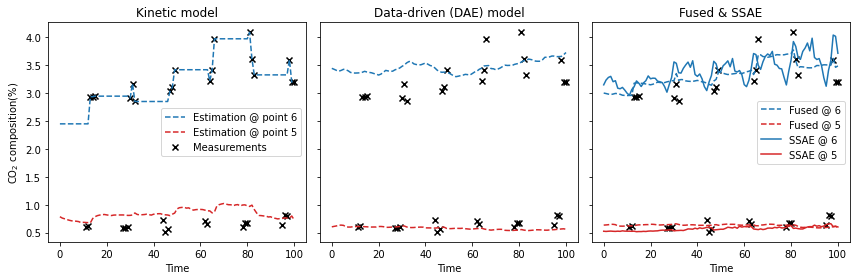

In [10]:
discrete_record = list_of_origin_df[2]['AT400(CO2 %)'][callback:]
sample45 = np.where(discrete_record >0.5,discrete_record,None)
ssae_set_6 = np.load('results/set1_6.npy')
ssae_set_5 = np.load('results/set1_5.npy')
fig, axs = plt.subplots(1,3, sharey=True, figsize=(12,4))
#plt.ylim(-0, 4.5)
#axs[0].plot(conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)))
plt.subplots_adjust(wspace = 0.05, bottom=0.15)
fig.set_tight_layout(True)
axs[0].scatter(range(predict_set.shape[0]), sample45, marker='x', color='black', label='Measurements')
axs[0].plot(test_full_values[:,5]*100,linestyle='dashed',color='tab:blue',label='Estimation @ point 6')
axs[0].plot(test_full_values[:,4]*100,linestyle='dashed',color='tab:red',label='Estimation @ point 5')
axs[0].set_title('Kinetic model')
axs[0].set_ylabel('CO$_2$ composition(%)')
axs[0].set_xlabel('Time')
axs[0].legend()
axs[1].scatter(range(predict_set.shape[0]), sample45, marker='x', color='black', label='Measurements')
axs[1].plot(predict_set[:,5],linestyle='dashed',color='tab:blue')
axs[1].plot(predict_set[:,4],linestyle='dashed',color='tab:red')
axs[1].set_title('Data-driven (DAE) model')
axs[1].set_xlabel('Time')
axs[2].scatter(range(predict_set.shape[0]), sample45, marker='x', color='black')
axs[2].plot(conc_set[:,5],linestyle='dashed',color='tab:blue',label='Fused @ 6')
axs[2].plot(conc_set[:,4],linestyle='dashed',color='tab:red',label='Fused @ 5')
axs[2].plot(ssae_set_6,color='tab:blue',label='SSAE @ 6')
axs[2].plot(ssae_set_5,color='tab:red', label='SSAE @ 5')
axs[2].set_title('Fused & SSAE')
axs[2].set_xlabel('Time')
axs[2].legend()
#plt.tight_layout()
#plt.savefig('compare_set2.png',dpi=1000)

<ipython-input-4-66e0fdabe42e>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AT400(CO2 %)']=pd.Series(data=conc_list,index=df.index)


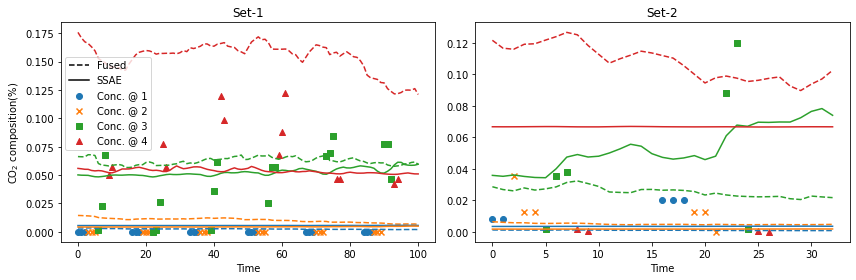

In [11]:
def columnSeparator2(df):
    df = avgOutPoint1(df)
    arr = np.ones((df.shape[0],4))
    for i in range(df.shape[0]):
        label = df['label'].iloc[i]
        if label < 4.5:
            arr[i,label-1] = df['AT400(CO2 %)'].iloc[i]
        else:
            arr[i] = None
    arr = np.where(arr!=1, arr, None)
    return arr
df_set1=list_of_origin_df[2][callback:]
df_set2=list_of_origin_df[1][callback:]
set1_arr = columnSeparator2(df_set1)
set2_arr = columnSeparator2(df_set2)

discrete_record_set1, discrete_record_set2  = list_of_origin_df[2]['AT400(CO2 %)'][callback:], list_of_origin_df[1]['AT400(CO2 %)'][callback:]
ssae_set1_1,ssae_set1_2,ssae_set1_3,ssae_set1_4 = np.load('results/set1_1.npy'),np.load('results/set1_2.npy'),np.load('results/set1_3.npy'),np.load('results/set1_4.npy')
ssae_set2_1,ssae_set2_2,ssae_set2_3,ssae_set2_4 = np.load('results/set2_1.npy'),np.load('results/set2_2.npy'),np.load('results/set2_3.npy'),np.load('results/set2_4.npy')

set1_kinetic, set2_kinetic = np.load('results/set1_kinetic.npy'),np.load('results/set2_kinetic.npy')
set1_fused, set2_fused = np.load('results/set1_fused.npy'),np.load('results/set2_fused.npy')
set1_dae, set2_dae = np.load('results/set1_DAE_16.npy'),np.load('results/set2_DAE_16.npy')
fig, axs = plt.subplots(1,2, sharey=False, figsize=(12,4))
plt.subplots_adjust(wspace = 0.05, bottom=0.15)
fig.set_tight_layout(True)
axs[0].scatter(range(set1_arr.shape[0]),set1_arr[:,0],marker='o',label='Conc. @ 1')
axs[0].scatter(range(set1_arr.shape[0]),set1_arr[:,1],marker='x',label='Conc. @ 2')
axs[0].scatter(range(set1_arr.shape[0]),set1_arr[:,2],marker='s',label='Conc. @ 3')
axs[0].scatter(range(set1_arr.shape[0]),set1_arr[:,3],marker='^',label='Conc. @ 4')
axs[0].plot(0,linestyle='dashed',color='black',label='Fused')
axs[0].plot(set1_fused[:,0],linestyle='dashed',color='tab:blue')
axs[0].plot(set1_fused[:,1],linestyle='dashed',color='tab:orange')
axs[0].plot(set1_fused[:,2],linestyle='dashed',color='tab:green')
axs[0].plot(set1_fused[:,3],linestyle='dashed',color='tab:red')
axs[0].plot(0,linestyle='-',color='black',label='SSAE')
axs[0].plot(ssae_set1_1,linestyle='-',color='tab:blue')
axs[0].plot(ssae_set1_2,linestyle='-',color='tab:orange')
axs[0].plot(ssae_set1_3,linestyle='-',color='tab:green')
axs[0].plot(ssae_set1_4,linestyle='-',color='tab:red')
#axs[0].plot(test_full_values[:,4]*100,linestyle='dashed',color='tab:red',label='Estimation @ point 5')
axs[0].set_title('Set-1')
axs[0].set_ylabel('CO$_2$ composition(%)')
axs[0].set_xlabel('Time')
axs[0].legend(loc=(0.01,0.42))
axs[1].scatter(range(set2_arr.shape[0]),set2_arr[:,0],marker='o')
axs[1].scatter(range(set2_arr.shape[0]),set2_arr[:,1],marker='x')
axs[1].scatter(range(set2_arr.shape[0]),set2_arr[:,2],marker='s')
axs[1].scatter(range(set2_arr.shape[0]),set2_arr[:,3],marker='^')
axs[1].plot(set2_fused[:,0],linestyle='dashed',color='tab:blue')
axs[1].plot(set2_fused[:,1],linestyle='dashed',color='tab:orange')
axs[1].plot(set2_fused[:,2],linestyle='dashed',color='tab:green')
axs[1].plot(set2_fused[:,3],linestyle='dashed',color='tab:red')
axs[1].plot(ssae_set2_1,linestyle='-',color='tab:blue')
axs[1].plot(ssae_set2_2,linestyle='-',color='tab:orange')
axs[1].plot(ssae_set2_3,linestyle='-',color='tab:green')
axs[1].plot(ssae_set2_4,linestyle='-',color='tab:red')
axs[1].set_title('Set-2')
axs[1].set_xlabel('Time')
plt.savefig('compare_upper.png',dpi=1000)

In [12]:
# Note: Switch to set3 scenario i.e., test: [1,2]
list_of_processed_df=list_of_origin_df.copy()
test_df_index_list=[1,2] # Select the index of test dataset
callback=17
train_sample_set, train_label_set, test_sample_set, test_label_set, conc_scaler,train_df_list,test_df_list,test_conc_list \
=getDataSet(data_path_list,list_of_processed_df, callback,test_df_index_list, 'POD', 32)
n_set = train_sample_set.shape[0]
train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
test_index = list(set(range(0,n_set,5)))
x_train = train_sample_set[train_index]; x_val = train_sample_set[test_index]
y_train = train_label_set[train_index]; y_val = train_label_set[test_index]
y_val

set3_ssae = np.zeros((conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6)).shape))
for i in range(6):
    set3_ssae[:,i] = np.load('results/set3_'+str(i+1)+'.npy').ravel()
print('RMSE of SSAE on test: ',rmse(set3_ssae, conc_scaler.inverse_transform(test_label_set.reshape(test_label_set.shape[0],6))))
set3_ssae = np.zeros((y_val.shape[0],6))
for i in range(6):
    set3_ssae[:,i] = np.load('results/set3_val_'+str(i+1)+'.npy').ravel()
print('RMSE of SSAE on val: ',rmse(set3_ssae, y_val))

Timestamp in selected Test df list: 
140206_1.xlsx
140207_1.xlsx
Origin input DF feature num(excl time, incl. label):  91
Conc scaler max:  [12.03671837]
Minimum call back is:  1
The smallest feasible callback is:  1
train list:  6
Train df(1st one) shape before POD:  (117, 97)
Test df(1st one) shape before POD:  (50, 97)
Truncation parameter:  32
Train:  0.00020657505898268987
Val:  0.00020325999653631073
Test:  0.005828281701551702
Train df(1st one) shape after AE:  (117, 39)
Test df(1st one) shape after AE:  (50, 39)
Number of set:  100
Number of set:  33
Number of set:  50
Number of set:  33
Number of set:  201
Number of set:  211
Number of set:  33
Number of set:  101
RMSE of SSAE on test:  0.4119852671537521
RMSE of SSAE on val:  2.381124839767557
